<a href="https://colab.research.google.com/github/harvey2phase/rrh-MNIST/blob/main/cnn_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
GDRIVE = '/content/gdrive'
drive.mount(GDRIVE)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Setup

In [ ]:
import os

MY_DRIVE = "/content/gdrive/My Drive/"

def mkdir(path):
    if os.path.exists(path):
        print("Directory %s already exists!" % path)
    else:
        try:
            os.mkdir(path)
        except OSError:
            print("Creation of the directory %s failed" % path)
        else:
            print("Successfully created the directory %s " % path)

In [ ]:
import seaborn as sns
sns.set()

In [ ]:
import datetime

import urllib
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.optim.lr_scheduler import StepLR

GPU = True
device = torch.device("cuda:0" if GPU and torch.cuda.is_available() else "cpu")

In [ ]:
def plot(x, x_recon):
    count = 0
    for i in range(10):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(np.linspace(0, 127, 128), x.detach().cpu()[i], c = "blue")
        ax.scatter(np.linspace(0, 127, 128), x_recon.detach().cpu()[i], c = "red")
        plt.show()

# Load MNIST

In [ ]:
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000

In [ ]:
def load_mnist(train, batch_size):
    img_transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,)),
    ])
    
    dataset = MNIST(
        root = './data/MNIST',
        download = True,
        train = train,
        transform = img_transform,
    )
    return DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [ ]:
train_dataloader = load_mnist(True, TRAIN_BATCH_SIZE)
test_dataloader = load_mnist(False, TEST_BATCH_SIZE)

In [ ]:
# Place into numpy arrays for easier manipulation
traindata = list(train_dataloader)
traindata = [[sample[0].numpy(), sample[1].numpy()] for sample in traindata]
train_X = np.vstack([sample[0] for sample in traindata])
train_y = np.hstack([sample[1] for sample in traindata])

testdata = list(test_dataloader)
testdata = [[sample[0].numpy(), sample[1].numpy()] for sample in testdata]
test_X = np.vstack([sample[0] for sample in testdata])
test_y = np.hstack([sample[1] for sample in testdata])

# Model Definitions

In [ ]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = False

## CNN

In [ ]:
CNN_EPOCH = 14
LR = 1.0
GAMMA = 0.7

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.penultimate_layers(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

    def penultimate_layers(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

### Training and Evaluation

In [ ]:
def train(model, optimizer):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            # get the index of the max log-probability
            pred = output.argmax(dim = 1, keepdim = True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

### Train and save CNN

In [ ]:
def create_and_train_cnn():
    cnn = Net().to(device)
    optimizer = torch.optim.Adadelta(cnn.parameters(), lr = LR)
    
    scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)
    for epoch in range(1, CNN_EPOCH + 1):
        train(cnn, optimizer)
        test(cnn)
        scheduler.step()
        
    date = datetime.date.today().strftime("%m-%d")
    model_name = date + "_epoch=" + str(CNN_EPOCH) + ".pth"
    optimizer_name = date + "_adadelta" + ".pth"
    torch.save(cnn.state_dict(), MY_DRIVE + "cnn/" + model_name)
    torch.save(optimizer.state_dict(), MY_DRIVE + "cnn/" + optimizer_name)
    return cnn

### Load saved CNN

In [ ]:
def load_cnn(model_name, optimizer_name = None):
    cnn = Net()
    cnn.load_state_dict(torch.load(MY_DRIVE + "cnn/" + model_name))
    cnn.to(device)
    return cnn

## VAE

In [ ]:
LAT_DIM = 2
CAPACITY = 64
LRN_RATE = 1e-3
VAR_BETA = 1

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.hidden1 = nn.Linear(
            in_features = 128,
            out_features = CAPACITY,
        )
        self.dropout1 = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm1d(CAPACITY)
        self.fc_mu = nn.Linear(
            in_features = CAPACITY,
            out_features = LAT_DIM,
        )
        self.fc_logvar = nn.Linear(
            in_features = CAPACITY,
            out_features = LAT_DIM,
        )
        
    def forward(self, x):
        x = self.hidden1(x)
        #x = self.bn1(x)
        x = F.relu(x)
        #x = self.dropout1(x)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.hidden1 = nn.Linear(
            in_features = LAT_DIM,
            out_features = CAPACITY,
        )
        self.dropout1 = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm1d(CAPACITY)
        self.output = nn.Linear(
            in_features = CAPACITY,
            out_features = 128,
        )

    def forward(self, x):
        x = self.hidden1(x)
        #x = self.bn1(x)
        x = F.relu(x)
        #x = self.dropout1(x)
        x = self.output(x)
        x = x.view(x.size(0), 128)
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

In [ ]:
def reconstruction_error(recon_x, x):
    return F.mse_loss(
        recon_x.view(-1, 128),
        x.view(-1, 128),
        reduction = "sum",
    )

def vae_loss(recon_loss, mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + VAR_BETA * kl_divergence

### Training and Evaluation



In [ ]:
def train_vae(
    vae = None, optimizer = None, evaluate = True, norm = True, 
):
    """ Trains, and returns one VAE model """
    
    if vae == None:
        vae = VariationalAutoencoder()
        vae = vae.to(device)
    
    if optimizer == None:
        optimizer = torch.optim.Adam(
            params = vae.parameters(),
            lr = LRN_RATE,
            weight_decay = 1e-5,
        )
    
    num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
    print('Number of parameters: %d' % num_params)
    
    vae.train()
    
    if evaluate:
        train_recon_loss, train_loss = [], []
        test_recon_loss, test_loss = [], []
    
    print("Training: ", end = "")
    for epoch in range(VAE_EPOCH):
        if evaluate:
            train_loss.append(0)
            train_recon_loss.append(0)
        num_batches = 0
        
        for image_batch, _ in train_dataloader:
            
            image_batch = image_batch.to(device)
            image_batch = cnn.penultimate_layers(image_batch)
    
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
            #plot(image_batch, image_batch_recon)
            
            recon_loss = reconstruction_error(image_batch_recon, image_batch)
            loss = vae_loss(recon_loss, latent_mu, latent_logvar)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if evaluate:
                train_loss[-1] += loss.item()
                train_recon_loss[-1] += recon_loss
                
            num_batches += 1
            
        if evaluate:
            train_loss[-1] /= num_batches
            train_loss[-1] /= TRAIN_BATCH_SIZE
            train_recon_loss[-1] /= num_batches
            train_recon_loss[-1] /= TRAIN_BATCH_SIZE
        
            recon_loss_avg, loss_avg = eval_model(vae)
            test_recon_loss.append(recon_loss_avg / TEST_BATCH_SIZE)
            test_loss.append(loss_avg / TEST_BATCH_SIZE)
            
            recon_loss_avg, loss_avg = eval_model(vae)

            vae.train()
        
        print("%d, " % (epoch+1), end = "")
        
    print()
    if evaluate:
        return (
            vae, optimizer,
            [np.array(train_loss), np.array(train_recon_loss)],
            [np.array(test_loss), np.array(test_recon_loss)],
        )
    return vae, optimizer

In [ ]:
def eval_model(vae):
    vae.eval()
    
    test_loss_avg, test_recon_loss_avg, num_batches = 0, 0, 0
    sum = 0
    for image_batch, _ in test_dataloader:
        
        with torch.no_grad():
        
            image_batch = image_batch.to(device)
            image_batch = cnn.penultimate_layers(image_batch)
    
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
            #plot(image_batch, image_batch_recon)
            
            recon_loss = reconstruction_error(image_batch_recon, image_batch)
            loss = vae_loss(recon_loss, latent_mu, latent_logvar)
    
            test_recon_loss_avg += recon_loss
            test_loss_avg += loss.item()
            num_batches += 1
        
    test_recon_loss_avg /= num_batches
    test_loss_avg /= num_batches

    return test_recon_loss_avg, test_loss_avg
    #print('average reconstruction error: %f' % (test_recon_loss_avg))
    #print('average error: %f' % (test_loss_avg))

In [ ]:
def plot_loss(train_losses, test_losses):
    plt.ion()

    plotlabels = ["Total error", "Reconstruction error", "KL divergence"]
    train_losses.append(train_losses[0] - train_losses[1])
    test_losses.append(test_losses[0] - test_losses[1])
    
    ncols = 3
    fig, ax = plt.subplots(ncols = ncols, figsize = (9, 2.5))
    
    for i in range(ncols): 
        ax[i].plot(train_losses[i], c = "blue", label = "training")
        ax[i].plot(test_losses[i], c = "green", label = "test")
            
        ax[i].set_title(plotlabels[i])
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend()
    #plt.show()
    plt.savefig(os.path.join(RESULTS_FOLDER, "training_curve.png"), dpi = 600)

### Load VAE

In [ ]:
def load_vae(folder_name, vae_name, optimizer_name = "adam.pth"):
    folder_name = os.path.join(RESULTS, folder_name)
    
    vae = VariationalAutoencoder()
    vae.load_state_dict(torch.load(os.path.join(folder_name, vae_name)))
    vae.to(device)
    optimizer = torch.optim.Adam(
        params = vae.parameters(),
        lr = LRN_RATE,
        weight_decay = 1e-5,
    )
    optimizer.load_state_dict(torch.load(
        os.path.join(folder_name, optimizer_name)
    ))
    return vae, optimizer

# RRH for Gaussian Mixtures

In [ ]:
def scale_to_cov(scales):
    return np.vstack([np.expand_dims(np.diagflat(s), 0) for s in scales])

def pool_covariance(means, covs):
    K = covs.shape[0] 
    p = np.repeat(1/K, K)
    cov_ = np.einsum('ijk,i->jk', covs, p) + np.einsum('ij,ik,i->jk', means, means, p)
    mu_ = np.einsum('ij,i->j', means, p)
    return cov_ - np.einsum('i,j->ij', mu_, mu_)
    
def mvn_renyi(C, q=1):
    """ Computes the Rényi heterogeneity for a multivariate Gaussian 
    Arguments: 
        C: `ndarray((n,n))`. Covariance matrix
        q: `0<float`. Order of the heterogeneity
    Returns: 
        `float`
    """
    n = C.shape[0]
    SqrtDetC = np.sqrt(np.linalg.det(C))
    if q == 1: 
        out = (2*np.pi*np.e)**(n/2) * SqrtDetC
    elif q == np.inf: 
        out = (2*np.pi)**(n/2) * SqrtDetC
    elif q!=1 and q!=0 and q!=np.inf:
        out = ((2*np.pi)**(n/2))*(q**(n/(2*(q-1))))*SqrtDetC
    return out

def mvn_renyi_alpha(C,  q=1):
    """ Computes the alpha-heterogeneity for a Gaussian mixture where each sample has equal weight

    Arguments: 

        cov: `ndarray((nsamples, n, n))`. Covariance matrices 
        q: `0<float`. Order of the heterogeneity metric

    Returns: 

        `float`. The alpha-heterogeneity
    """
    K, n, _ = C.shape
    p = np.repeat(1/K, K)
    if q == 1:
        out = np.exp((n + np.sum(p*np.log(np.linalg.det(2*np.pi*C))))/2)
    elif q!=np.inf and q!=1 and q!=0:
        wbar = (p**q)/np.sum(p**q)
        out = ((2*np.pi)**(n/2))*np.sum(wbar*np.sqrt(np.linalg.det(C)))/(q**(n/2))**(1/(1-q))
    return out

## Calculation

In [ ]:
def calculate_rrh(vae, X = train_X, y = train_y):
    gammas, alphas, betas = [], [], []
    for i in range(10):
        mu, logvar = vae.encoder(
            cnn.penultimate_layers(torch.Tensor(X[y == i]).to(device)),
        )
        loc = mu.cpu().detach().numpy()
        scale = logvar.exp().cpu().detach().numpy()
        cov = scale_to_cov(scale)
        gamma = mvn_renyi(pool_covariance(loc, cov), q=1)
        alpha = mvn_renyi_alpha(cov,q=1)
        beta = gamma/alpha
        gammas.append(gamma)
        alphas.append(alpha)
        betas.append(beta)
    return np.array(gammas), np.array(alphas), np.array(betas)


def het_sigma(matrix, avg = None):
    if avg == None:
        avg = het_avg(matrix)
    n = len(matrix)
    mse = (matrix[0] - avg) ** 2
    for i in range(1, n):
        mse += (matrix[i] - avg) ** 2
    return np.sqrt(mse / n)

def het_sum(matrix):
    sum = matrix[0] + matrix[1]
    for i in range(2, len(matrix)):
        sum += matrix[i]
    return sum

def het_avg(matrix):
    return het_sum(matrix) / len(matrix)

## Plotting

In [ ]:
def plot_rrh(gammas, alphas, betas, filename, sigmas = None):
    if not (len(gammas) == len(alphas) or len(gammas) == len(betas)):
        sys.exit("Mismatched matrix size")
    n = len(gammas)
    hetvalues = [gammas, alphas, betas]
    plotlabels = [r"Pooled", r"Within-Observation", r"Between-Observation"]
    
    fig, ax = plt.subplots(ncols=3, figsize=(9, 2.5))
    ax[0].set_ylabel("Heterogeneity")
    
    for i in range(3): 
        ax[i].set_title(plotlabels[i])
        ax[i].set_xticks(np.arange(10))
        ax[i].set_xticklabels(np.arange(10))
        ax[i].bar(
            np.arange(10),
            hetvalues[i],
            facecolor = plt.get_cmap("Greys")(0.4), 
            edgecolor = "black",
        )
        if not sigmas == None:
            ax[i].errorbar(
                np.arange(10),
                hetvalues[i],
                yerr = sigmas[i],
                fmt = "none",
                ecolor = "r",
                capsize = 3,
                label = "std deviation",
            )
            ax[i].errorbar(
                np.arange(10),
                hetvalues[i],
                yerr = sigmas[i] / np.sqrt(n),
                fmt = "none",
                ecolor = "b",
                capsize = 3,
                label = "std error",
            )
    plt.tight_layout()
    #plt.show()
    plt.savefig(os.path.join(RESULTS_FOLDER, filename + ".png"), dpi = 600)

# Experiments

In [ ]:
#cnn = create_and_train_cnn()
cnn = load_cnn("12-18_epoch=14.pth")
freeze(cnn)

In [ ]:
RESULTS = os.path.join(MY_DRIVE, "results")
mkdir(RESULTS)

RESULTS_FOLDER = os.path.join(
    RESULTS, datetime.datetime.now().strftime("%m-%d_%H-%M"),
)
mkdir(RESULTS_FOLDER)

Directory /content/gdrive/My Drive/results already exists!
Directory /content/gdrive/My Drive/results/12-18_01-01 already exists!


In [ ]:
VAE_EPOCH = 10
epoch = 0
#vae1, optimizer = load_vae("12-18_00-27", vae_name = "vae_epoch=30.pth")
vae1, optimizer, train_losses, test_losses = train_vae(
    #vae = vae1, optimizer = optimizer,
    evaluate = True,
)

torch.save(vae1.state_dict(), os.path.join(
    RESULTS_FOLDER, "vae_epoch=" + str(epoch + VAE_EPOCH) + ".pth"
))
torch.save(optimizer.state_dict(), os.path.join(RESULTS_FOLDER, "adam.pth"))
with open(os.path.join(RESULTS_FOLDER, "vae.txt"), "w+") as f:
    f.write(str(vae1))
drive.flush_and_unmount()
drive.mount(GDRIVE)

Number of parameters: 17284
Training: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
Mounted at /content/gdrive


In [ ]:
recon_loss_avg, loss_avg = eval_model(vae1)

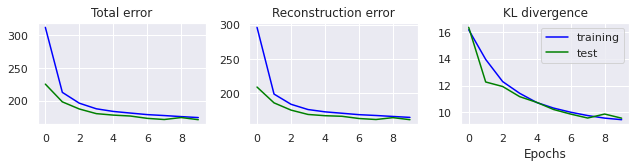

In [ ]:
plot_loss(train_losses, test_losses)

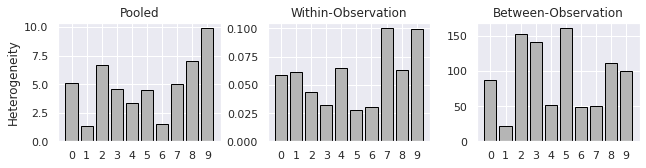

In [ ]:
gammas, alphas, betas = calculate_rrh(vae1)
plot_rrh(gammas, alphas, betas, filename = "het_train")

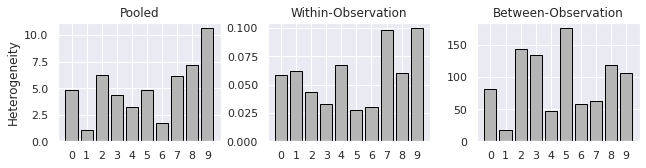

In [ ]:
gammas, alphas, betas = calculate_rrh(
    vae1, X = test_X, y = test_y,
)
plot_rrh(gammas, alphas, betas, filename = "het_test")